<a href="https://colab.research.google.com/github/daycardoso/bert-vs-modernbert-valueeval24/blob/main/pre_process_valores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicialização

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
import os
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')

Mounted at /content/drive


In [3]:
import pandas as pd
import json
import os # Adicionado para construir os caminhos

# Carregar os Dados em Ingles
home = "/content/drive/MyDrive/Mestrado/DetectionOfHumanValuesInTexts/Colab_Experimentos/"

folder_treino = home + "training-english/"
folder_validacao = home + "validation-english/"
folder_teste = home + "test-english/"

# Json value-categories - Carregue o JSON uma única vez
caminho_json_valores = os.path.join(home, "value-categories.json")
with open(caminho_json_valores, 'r') as f:
    categorias_valores = json.load(f)

df_sentences_train = pd.read_csv(folder_treino + "sentences.tsv", sep='\t')
df_labels_train = pd.read_csv(folder_treino + "labels.tsv", sep='\t')
sentences_file_train = folder_treino + "sentences_fundido_resample.tsv"
labels_file_train = folder_treino + "labels_fundido_resample.tsv"

df_sentences_valid = pd.read_csv(folder_validacao + "sentences.tsv", sep='\t')
df_labels_valid = pd.read_csv(folder_validacao + "labels.tsv", sep='\t')
sentences_file_valid = folder_validacao + "sentences_fundido_resample.tsv"
labels_file_valid = folder_validacao + "labels_fundido_resample.tsv"

df_sentences_test = pd.read_csv(folder_teste + "sentences.tsv", sep='\t')
df_labels_test = pd.read_csv(folder_teste + "labels.tsv", sep='\t')
sentences_file_test = folder_teste + "sentences.tsv"
labels_file_test = folder_teste + "labels.tsv"

# Json value-categories
categorias_valores = json.load(open(home + "value-categories.json"))

df_sentences_train.head()
df_sentences_train.describe()

,Sentence-ID
count,44758.000000
mean,16.530475
std,11.499004
min,1.000000
25%,7.000000
50%,15.000000
75%,23.000000
max,82.000000


In [4]:
# Verificar a quantidade de tokens em cada sentença
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

def count_tokens(text):
    return len(tokenizer.encode(text))
    # return len(text.split())

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [5]:
def processar_e_fundir_sentencas_treino(caminho_dos_dados: str) -> tuple[str, str]:
    """
    Carrega dados de sentenças e rótulos. Para sentenças sem rótulo,
    concatena seu texto à sentença vizinha mais próxima que possui um rótulo e
    remove a sentença original sem rótulo. Por fim, enriquece o texto
    restante com os nomes dos valores.

    Args:
        caminho_dos_dados (str): O caminho para o diretório com os arquivos.

    Returns:
        tuple[str, str]: Os caminhos para os novos arquivos gerados.
    """
    # Etapa 1: Carregar os dados
    caminho_sentencas = os.path.join(caminho_dos_dados, 'sentences.tsv')
    caminho_labels = os.path.join(caminho_dos_dados, 'labels.tsv')

    df_sentencas = pd.read_csv(caminho_sentencas, sep='\t')
    df_labels = pd.read_csv(caminho_labels, sep='\t')

    nomes_colunas_labels = df_labels.columns[2:].tolist()
    df_combinado = pd.merge(df_sentencas, df_labels, on=['Text-ID', 'Sentence-ID'])

    # Etapa 2: Lógica de "Fundir e Descartar"
    indices_para_descartar = []

    # Agrupa por texto para garantir que a busca por vizinhos seja feita dentro do mesmo documento
    for _, grupo in df_combinado.groupby('Text-ID'):
        # Identifica as sentenças com e sem rótulos dentro do grupo
        sem_labels_mask = grupo[nomes_colunas_labels].sum(axis=1) == 0
        indices_sem_labels = grupo[sem_labels_mask].index
        indices_com_labels = grupo[~sem_labels_mask].index

        # Se não houver sentenças sem rótulos ou com rótulos para servir de base, pula para o próximo grupo
        if indices_sem_labels.empty or indices_com_labels.empty:
            continue

        # Para cada sentença sem rótulo, encontra a vizinha mais próxima e funde o texto
        for idx_sem_label in indices_sem_labels:
            distancias = abs(indices_com_labels - idx_sem_label)
            idx_mais_proximo = indices_com_labels[distancias.argmin()]

            # Concatena o texto da sentença sem rótulo à sua vizinha mais próxima
            texto_para_fundir = df_combinado.loc[idx_sem_label, 'Text']
            df_combinado.loc[idx_mais_proximo, 'Text'] += " " + texto_para_fundir

            # Adiciona o índice da sentença que foi fundida à lista de descarte
            indices_para_descartar.append(idx_sem_label)

    # Após o loop, descarta todas as sentenças que foram fundidas
    df_processado = df_combinado.drop(indices_para_descartar).reset_index(drop=True)

    # Etapa 3: Enriquecer o texto das sentenças restantes
    def enriquecer_texto(linha):
        texto_original = linha['Text']
        nomes_encontrados = set()
        for nome_coluna in nomes_colunas_labels:
            if linha[nome_coluna] > 0:
                nome_base = nome_coluna.removesuffix(' attained').removesuffix(' constrained')
                # nome_final = f"[VALOR: {nome_base}]"
                # nomes_encontrados.add(nome_final)

        if nomes_encontrados:
            # O texto da linha já pode conter o texto fundido de outras sentenças
            return f"{texto_original} {' '.join(sorted(list(nomes_encontrados)))}"
        return texto_original

    df_processado['Text'] = df_processado.apply(enriquecer_texto, axis=1)

    # Etapa 4: Salvar os arquivos finais
    df_sentencas_novo = df_processado[['Text-ID', 'Sentence-ID', 'Text']]
    df_labels_novo = df_processado[df_labels.columns]

    caminho_sentencas_novo = os.path.join(caminho_dos_dados, 'sentences_fundido.tsv')
    caminho_labels_novo = os.path.join(caminho_dos_dados, 'labels_fundido.tsv')

    df_sentencas_novo.to_csv(caminho_sentencas_novo, sep='\t', index=False)
    df_labels_novo.to_csv(caminho_labels_novo, sep='\t', index=False, header=True)

    return caminho_sentencas_novo, caminho_labels_novo

In [6]:
# Realizar o resample descrito acima nos dados de treino, ajustando o numero de sentença e adicionando a label no dataset de label
MAX_TOKENS = 128

def split_tokens_at_period(tokens: list[int], max_tokens: int, period_id: int) -> list[list[int]]:
    """
    Divide uma lista de token ids em chunks de até max_tokens, preferencialmente
    cortando após o token de ponto final (period_id). Se não encontrar um ponto
    antes de estourar max_tokens, corta exatamente no limite.
    """
    chunks = []
    start = 0
    last_period = None

    for i, tid in enumerate(tokens):
        # Marca a posição do último ponto
        if tid == period_id:
            last_period = i

        # Quando excede max_tokens, define boundary
        if i - start + 1 > max_tokens:
            if last_period is not None and last_period >= start:
                boundary = last_period + 1
            else:
                boundary = start + max_tokens

            chunks.append(tokens[start:boundary])
            start = boundary
            last_period = None

    # Pedaço final
    if start < len(tokens):
        chunks.append(tokens[start:])

    return chunks


def resample_dataset(df_sentences: pd.DataFrame, df_labels: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Resamples the dataset by splitting long sentences into chunks that end
    at periods when possível, respeitando MAX_TOKENS. Labels são duplicados.
    """
    df_combined = pd.merge(df_sentences, df_labels, on=['Text-ID', 'Sentence-ID'])
    new_sentences, new_labels = [], []
    label_cols = df_labels.columns[2:].tolist()

    # id do token "."
    period_id = tokenizer.convert_tokens_to_ids(".")

    for _, row in df_combined.iterrows():
        text      = row['Text']
        text_id   = row['Text-ID']
        sent_id   = row['Sentence-ID']
        labels    = row[label_cols].values

        tokens = tokenizer.encode(text, add_special_tokens=False)

        if len(tokens) <= MAX_TOKENS:
            # curva curta, sem split
            new_sentences.append({
                'Text-ID': text_id,
                'Sentence-ID': sent_id,
                'Text': text
            })
            new_labels.append([text_id, sent_id] + labels.tolist())

        else:
            # quebra em chunks preferenciais em "."
            chunks = split_tokens_at_period(tokens, MAX_TOKENS, period_id)

            for idx, chunk in enumerate(chunks, start=1):
                chunk_text = tokenizer.decode(chunk).strip()
                new_id = f"{sent_id}_{idx}"
                new_sentences.append({
                    'Text-ID': text_id,
                    'Sentence-ID': new_id,
                    'Text': chunk_text
                })
                new_labels.append([text_id, new_id] + labels.tolist())

    df_samp = pd.DataFrame(new_sentences)
    df_lbls = pd.DataFrame(new_labels, columns=df_labels.columns)
    return df_samp, df_lbls

# Treino

In [7]:
df_sentences_train['num_tokens'] = df_sentences_train['Text'].apply(count_tokens)
df_sentences_train.describe()

,Sentence-ID,num_tokens
count,44758.000000,44758.000000
mean,16.530475,28.485165
std,11.499004,17.247903
min,1.000000,3.000000
25%,7.000000,17.000000
50%,15.000000,25.000000
75%,23.000000,36.000000
max,82.000000,353.000000


In [8]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train[df_sentences_train['num_tokens'] < 10].describe()

,Sentence-ID,num_tokens
count,2870.000000,2870.000000
mean,17.488153,7.195122
std,13.639320,1.643850
min,1.000000,3.000000
25%,6.000000,6.000000
50%,15.000000,8.000000
75%,25.000000,9.000000
max,80.000000,9.000000


In [9]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train[df_sentences_train['num_tokens'] < 5].describe()

,Sentence-ID,num_tokens
count,245.000000,245.000000
mean,15.391837,3.779592
std,12.793182,0.415370
min,1.000000,3.000000
25%,4.000000,4.000000
50%,13.000000,4.000000
75%,23.000000,4.000000
max,53.000000,4.000000


In [10]:
# Apply the same processing and resampling to the training data
novos_treino = processar_e_fundir_sentencas_treino(folder_treino)
df_sentences_train_rich = pd.read_csv(folder_treino + "sentences_fundido.tsv", sep='\t')
df_labels_train_rich = pd.read_csv(folder_treino + "labels_fundido.tsv", sep='\t')

# Count tokens and describe the resampled training data
df_sentences_train_rich['num_tokens'] = df_sentences_train_rich['Text'].apply(count_tokens)
df_sentences_train_rich.describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


,Sentence-ID,num_tokens
count,23089.000000,23089.000000
mean,15.803023,53.341461
std,11.062112,53.008213
min,1.000000,3.000000
25%,7.000000,25.000000
50%,14.000000,39.000000
75%,22.000000,63.000000
max,79.000000,1015.000000


In [11]:
# Fazer a analise qualitativa das sentença com menos de 10 tokens
df_sentences_train_rich[df_sentences_train_rich['num_tokens'] < 10].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
52,EN_006,8,Zero kids are proficient.,7
83,EN_010,1,USA goes full Psycho:,7
263,EN_045,4,He received high accolades from many,8
298,EN_047,20,) and the CDC.,7
752,EN_157,2,FEMALE TELEVISION,4
...,...,...,...,...
5751,DE_124,10,be completed by September.,7
5753,DE_124,12,May was agreed.,6
5823,DE_136,9,"""We calculated everything beforehand.""",9
5833,DE_136,21,Both criticized Moscow's actions.,9


In [12]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_rich[df_sentences_train_rich['num_tokens'] < 10].describe()

,Sentence-ID,num_tokens
count,383.000000,383.000000
mean,16.934726,7.652742
std,14.589440,1.381265
min,1.000000,3.000000
25%,5.000000,7.000000
50%,13.000000,8.000000
75%,25.000000,9.000000
max,78.000000,9.000000


In [13]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_rich[df_sentences_train_rich['num_tokens'] < 5].describe()

,Sentence-ID,num_tokens
count,12.000000,12.000000
mean,14.833333,3.750000
std,15.514412,0.452267
min,1.000000,3.000000
25%,2.750000,3.750000
50%,8.500000,4.000000
75%,20.000000,4.000000
max,46.000000,4.000000


In [14]:
df_sentences_train_resampled, df_labels_train_resampled = resample_dataset(df_sentences_train_rich, df_labels_train_rich)

# Count tokens and describe the resampled training data
df_sentences_train_resampled['num_tokens'] = df_sentences_train_resampled['Text'].apply(count_tokens)
df_sentences_train_resampled.describe()

,num_tokens
count,24916.000000
mean,49.577219
std,31.651833
min,3.000000
25%,25.000000
50%,40.000000
75%,66.000000
max,131.000000


In [15]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 10].describe()

,num_tokens
count,404.000000
mean,7.569307
std,1.468494
min,3.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,9.000000


In [16]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 5].describe()

,num_tokens
count,17.000000
mean,3.588235
std,0.507300
min,3.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,4.000000


In [17]:
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 10].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
54,EN_006,8,Zero kids are proficient.,7
85,EN_010,1,USA goes full Psycho:,7
322,EN_045,4,He received high accolades from many,8
357,EN_047,20,) and the CDC.,7
973,EN_157,2,FEMALE TELEVISION,4
...,...,...,...,...
6059,DE_098,16,Lambrecht improved once again.,8
6069,DE_098,26,The victims' birthday.,7
6144,DE_102,5,preferred such a design.,7
6337,DE_121,29,"However, it remained a thought.",9


In [18]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 7].describe()

,num_tokens
count,82.000000
mean,5.170732
std,0.953290
min,3.000000
25%,5.000000
50%,5.000000
75%,6.000000
max,6.000000


In [19]:
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 7].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
973,EN_157,2,FEMALE TELEVISION,4
1116,EN_181,26,We honor that.,6
1369,EN_226,6_2,moving out.,5
1737,EN_305,23_3,"""",3
2174,EN_386,3,Brooks,3
...,...,...,...,...
22495,TR_100,5,The epidemic escalated.,6
23361,TR_186,37,LOCALS DOMINATE.,5
23676,TR_213,1,Exemplary verdict!,5
23934,TR_237,30,Sanctions hurt people.,6


In [20]:
df_sentences_train_resampled, df_labels_train_resampled = resample_dataset(df_sentences_train_rich, df_labels_train_rich)

# Count tokens and describe the resampled training data
df_sentences_train_resampled['num_tokens'] = df_sentences_train_resampled['Text'].apply(count_tokens)
df_sentences_train_resampled.describe()

,num_tokens
count,24916.000000
mean,49.577219
std,31.651833
min,3.000000
25%,25.000000
50%,40.000000
75%,66.000000
max,131.000000


In [21]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 10].describe()

,num_tokens
count,404.000000
mean,7.569307
std,1.468494
min,3.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,9.000000


In [22]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 5].describe()

,num_tokens
count,17.000000
mean,3.588235
std,0.507300
min,3.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,4.000000


In [23]:
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 10].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
54,EN_006,8,Zero kids are proficient.,7
85,EN_010,1,USA goes full Psycho:,7
322,EN_045,4,He received high accolades from many,8
357,EN_047,20,) and the CDC.,7
973,EN_157,2,FEMALE TELEVISION,4
...,...,...,...,...
6059,DE_098,16,Lambrecht improved once again.,8
6069,DE_098,26,The victims' birthday.,7
6144,DE_102,5,preferred such a design.,7
6337,DE_121,29,"However, it remained a thought.",9


In [24]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 7].describe()

,num_tokens
count,82.000000
mean,5.170732
std,0.953290
min,3.000000
25%,5.000000
50%,5.000000
75%,6.000000
max,6.000000


In [25]:
df_sentences_train_resampled[df_sentences_train_resampled['num_tokens'] < 7].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
973,EN_157,2,FEMALE TELEVISION,4
1116,EN_181,26,We honor that.,6
1369,EN_226,6_2,moving out.,5
1737,EN_305,23_3,"""",3
2174,EN_386,3,Brooks,3
...,...,...,...,...
22495,TR_100,5,The epidemic escalated.,6
23361,TR_186,37,LOCALS DOMINATE.,5
23676,TR_213,1,Exemplary verdict!,5
23934,TR_237,30,Sanctions hurt people.,6


# Teste

In [26]:
df_sentences_test['num_tokens'] = df_sentences_test['Text'].apply(count_tokens)
df_sentences_test.describe()

,Sentence-ID,num_tokens
count,14569.000000,14569.000000
mean,16.688929,28.576223
std,12.002220,17.838588
min,1.000000,3.000000
25%,8.000000,16.000000
50%,15.000000,25.000000
75%,23.000000,36.000000
max,85.000000,383.000000


In [27]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_test[df_sentences_test['num_tokens'] < 10].describe()

,Sentence-ID,num_tokens
count,1002.000000,1002.000000
mean,17.699601,7.145709
std,13.980527,1.639524
min,1.000000,3.000000
25%,7.000000,6.000000
50%,15.000000,7.000000
75%,26.000000,9.000000
max,78.000000,9.000000


In [28]:
# Fazer a analise qualitativa das sentença com menos de 10 tokens
df_sentences_test[df_sentences_test['num_tokens'] < 10].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
1,EN_002,2,Madrid.,4
9,EN_002,10,Is it a necessity?,7
76,EN_031,7,Remuneration review.,7
82,EN_031,13,Loan sale.,5
90,EN_044,3,"Wed, 14 Jul, 2021",8
...,...,...,...,...
1527,EN_335,24,Picture: Tony Gavin.,7
1549,EN_338,14,Representing views.,5
1580,EN_346,22,Follow ERR News on,7
1595,EN_353,15,I have no idea.,7


In [29]:
df_sentences_test.head(20)

,Text-ID,Sentence-ID,Text,num_tokens
0,EN_002,1,Spain’s minister pleads for ‘millions and mill...,16
1,EN_002,2,Madrid.,4
2,EN_002,3,“The demographic trajectories are there.,12
3,EN_002,4,"It will happen, we will not escape it…” It is ...",37
4,EN_002,5,José Luis Escriva elaborated on the need for m...,23
5,EN_002,6,The minister detailed his plans during the OEC...,37
6,EN_002,7,The Spanish economy will therefore require “mi...,28
7,EN_002,8,"With 47 million inhabitants, the demography of...",20
8,EN_002,9,His statements were similar to those of Jean-P...,61
9,EN_002,10,Is it a necessity?,7


In [30]:
# Chamada principal para executar todo o processo corrigido
# novos_arquivos = processar_e_fundir_sentencas_treino(folder_treino)
# print(f"Arquivos processados e salvos em: {novos_arquivos}")

# df_sentences_train_rich = pd.read_csv(folder_treino + "sentences_fundido.tsv", sep='\t')
# df_labels_train_rich = pd.read_csv(folder_treino + "labels_fundido.tsv", sep='\t')
# df_labels_train_rich.describe()

# aplicar no teste
novos_testes = processar_e_fundir_sentencas_treino(folder_teste)
df_sentences_test_rich = pd.read_csv(folder_teste + "sentences_fundido.tsv", sep='\t')
df_labels_test_rich = pd.read_csv(folder_teste + "labels_fundido.tsv", sep='\t')
df_sentences_test_rich.describe()

,Sentence-ID
count,7402.000000
mean,15.601459
std,11.111394
min,1.000000
25%,7.000000
50%,14.000000
75%,22.000000
max,85.000000


In [31]:
df_sentences_test_rich.head(20)

,Text-ID,Sentence-ID,Text
0,EN_002,6,The minister detailed his plans during the OEC...
1,EN_002,7,The Spanish economy will therefore require “mi...
2,EN_002,8,"With 47 million inhabitants, the demography of..."
3,EN_002,11,"It would seem so, according to José Luis Escri..."
4,EN_002,12,"“Our population will be more mixed,” he added...."
5,EN_002,16,"“It’s a problem, we have to deal with irregula..."
6,EN_002,18,“European citizens want to welcome migrants in...
7,EN_002,19,"However, for those who have the right to stay,..."
8,EN_008,3,This is fast becoming a prerequisite ideologic...
9,EN_008,4,Boris Johnson revealed himself to be nowhere n...


In [32]:
df_sentences_test_rich['num_tokens'] = df_sentences_test_rich['Text'].apply(count_tokens)
df_sentences_test_rich.describe()

,Sentence-ID,num_tokens
count,7402.000000,7402.000000
mean,15.601459,54.308700
std,11.111394,52.345966
min,1.000000,4.000000
25%,7.000000,26.000000
50%,14.000000,40.000000
75%,22.000000,64.000000
max,85.000000,905.000000


In [33]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_test_rich[df_sentences_test_rich['num_tokens'] < 10].describe()

,Sentence-ID,num_tokens
count,121.000000,121.000000
mean,16.520661,7.867769
std,12.582461,1.328797
min,1.000000,4.000000
25%,6.000000,7.000000
50%,15.000000,8.000000
75%,26.000000,9.000000
max,59.000000,9.000000


In [34]:
# Fazer a analise qualitativa das sentença com menos de 10 tokens
df_sentences_test_rich[df_sentences_test_rich['num_tokens'] < 10].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
264,EN_210,15,Greek authorities investigate criminals.,7
276,EN_213,15,Pat never gave up faith.,8
584,BG_001,34,The Ukrainians could not pass.,9
586,BG_001,37,I expect a humanitarian crisis.,8
623,BG_022,12,Armed with assault rifles!!!,9
...,...,...,...,...
5988,NL_115,25,"That should be mandatory.""",8
6014,NL_132,1,Hungarian Prime Minister Orban:,8
6201,NL_239,13,We believe in it.,7
6300,NL_297,40,The attorney for R.,7


In [35]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_test_rich[df_sentences_test_rich['num_tokens'] < 6].describe()

,Sentence-ID,num_tokens
count,9.000000,9.000000
mean,12.000000,4.444444
std,10.511898,0.527046
min,2.000000,4.000000
25%,2.000000,4.000000
50%,11.000000,4.000000
75%,17.000000,5.000000
max,32.000000,5.000000


In [36]:
# Fazer a analise qualitativa das sentença com menos de 10 tokens
df_sentences_test_rich[df_sentences_test_rich['num_tokens'] < 6].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
821,BG_095,2,(Review),5
889,BG_108,6,"Anna.""",5
1300,BG_M_001,17,4.,4
2685,EL_113,13,Specifically:,4
3579,HE_001,2,Residents evacuate,4
4550,HE_190,32,the hole,4
4736,HE_M_009,11,public education.,5
4786,HE_M_020,23,Higher education,4
5146,IT_126,2,Refugee influx increases,5


In [37]:
# # Example usage:
# df_sentences_train_resampled, df_labels_train_resampled = resample_dataset(df_sentences_train_rich, df_labels_train_rich)
# print("Resampled Training Sentences:")
# display(df_sentences_train_resampled.head())
# print("\nResampled Training Labels:")
# display(df_labels_train_resampled.head())

# aplicar no teste
df_sentences_test_resampled, df_labels_test_resampled = resample_dataset(df_sentences_test_rich, df_labels_test_rich)
# Contar os tokens
df_sentences_test_resampled['num_tokens'] = df_sentences_test_resampled['Text'].apply(count_tokens)
df_sentences_test_resampled.describe()


,num_tokens
count,7979.000000
mean,50.526632
std,31.467793
min,3.000000
25%,26.000000
50%,42.000000
75%,68.000000
max,131.000000


In [38]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_test_resampled[df_sentences_test_resampled['num_tokens'] < 10].describe()

,num_tokens
count,132.000000
mean,7.666667
std,1.556404
min,3.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,9.000000


In [39]:
# Fazer a analise qualitativa das sentença com menos de 10 tokens
df_sentences_test_resampled[df_sentences_test_resampled['num_tokens'] < 10].head(100)


,Text-ID,Sentence-ID,Text,num_tokens
81,EN_079,21_2,with reporting from sean murray,7
94,EN_088,6_2,”,3
351,EN_210,15,Greek authorities investigate criminals.,7
364,EN_213,15,Pat never gave up faith.,8
441,EN_268,24_2,”,3
...,...,...,...,...
5691,IT_158,5,Record-breaking margin.,7
5756,IT_176,2,New record for Italian public debt.,9
5950,IT_239,11,The investigation ended in nothing.,8
5975,IT_M_007,1,Italy protagonist in Europe and the world,9


In [40]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_test_resampled[df_sentences_test_resampled['num_tokens'] < 6].describe()

,num_tokens
count,14.000000
mean,4.071429
std,0.730046
min,3.000000
25%,4.000000
50%,4.000000
75%,4.750000
max,5.000000


In [41]:
# Fazer a analise qualitativa das sentença com menos de 10 tokens
df_sentences_test_resampled[df_sentences_test_resampled['num_tokens'] < 6].head(20)

,Text-ID,Sentence-ID,Text,num_tokens
94,EN_088,6_2,”,3
441,EN_268,24_2,”,3
1031,BG_095,2,(Review),5
1099,BG_108,6,"Anna.""",5
1513,BG_M_001,17,4.,4
2875,EL_085,11_2,).,4
2943,EL_113,13,Specifically:,4
3230,EL_216,18_2,"""",3
3937,HE_001,2,Residents evacuate,4
4913,HE_190,32,the hole,4


**Irei usar os dados para teste obtidos depois do processo:**
```python
novos_testes = processar_e_fundir_sentencas_treino(folder_teste)
df_sentences_test_rich = pd.read_csv(folder_teste + "sentences_fundido.tsv", sep='\t')
df_labels_test_rich = pd.read_csv(folder_teste + "labels_fundido.tsv", sep='\t')
```

# Validação

In [42]:
df_sentences_valid['num_tokens'] = df_sentences_valid['Text'].apply(count_tokens)
df_sentences_valid.describe()

,Sentence-ID,num_tokens
count,14904.000000,14904.000000
mean,17.347759,28.427201
std,13.161916,17.733197
min,1.000000,3.000000
25%,8.000000,16.000000
50%,15.000000,25.000000
75%,24.000000,37.000000
max,125.000000,404.000000


In [43]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_valid[df_sentences_valid['num_tokens'] < 10].describe()

,Sentence-ID,num_tokens
count,1082.000000,1082.000000
mean,20.783734,6.981516
std,18.961019,1.757666
min,1.000000,3.000000
25%,7.000000,6.000000
50%,17.000000,7.000000
75%,28.000000,8.000000
max,121.000000,9.000000


In [44]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_valid[df_sentences_valid['num_tokens'] < 5].describe()

,Sentence-ID,num_tokens
count,134.000000,134.000000
mean,19.634328,3.753731
std,22.243540,0.432454
min,1.000000,3.000000
25%,6.000000,4.000000
50%,14.000000,4.000000
75%,24.000000,4.000000
max,115.000000,4.000000


In [45]:
# Apply the same processing and resampling to the validation data
novos_treino = processar_e_fundir_sentencas_treino(folder_validacao)
df_sentences_validation_rich = pd.read_csv(folder_validacao + "sentences_fundido.tsv", sep='\t')
df_labels_validation_rich = pd.read_csv(folder_validacao + "labels_fundido.tsv", sep='\t')

# Count tokens and describe the resampled validation data
df_sentences_validation_rich['num_tokens'] = df_sentences_validation_rich['Text'].apply(count_tokens)
df_sentences_validation_rich.describe()

,Sentence-ID,num_tokens
count,7600.000000,7600.000000
mean,16.053421,53.825132
std,11.398408,54.916200
min,1.000000,3.000000
25%,7.000000,25.000000
50%,14.000000,39.000000
75%,23.000000,64.000000
max,90.000000,1129.000000


In [46]:
# Fazer a analise qualitativa das sentença com menos de 10 tokens
df_sentences_validation_rich[df_sentences_validation_rich['num_tokens'] < 10].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
660,BG_005,27,"""Cold.""",6
713,BG_025,12,This is your essence.,7
901,BG_092,3,Hamburg.,4
917,BG_092,24,St.,4
952,BG_098,17,"""There are certain rules.",8
...,...,...,...,...
5091,IT_132,3,the latest news on the war .,9
5118,IT_149,2,Alghero is flying again.,9
5136,IT_153,2,Worldwide already lost 300 million jobs,8
5162,IT_160,2,But equities remain positive,8


In [47]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_validation_rich[df_sentences_validation_rich['num_tokens'] < 10].describe()

,Sentence-ID,num_tokens
count,137.000000,137.000000
mean,19.226277,7.890511
std,14.954339,1.343168
min,1.000000,3.000000
25%,3.000000,7.000000
50%,19.000000,8.000000
75%,28.000000,9.000000
max,56.000000,9.000000


In [48]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_validation_rich[df_sentences_validation_rich['num_tokens'] < 6].describe()

,Sentence-ID,num_tokens
count,9.000000,9.000000
mean,17.666667,4.333333
std,14.133294,0.707107
min,1.000000,3.000000
25%,3.000000,4.000000
50%,24.000000,4.000000
75%,28.000000,5.000000
max,38.000000,5.000000


In [49]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_validation_rich[df_sentences_validation_rich['num_tokens'] < 6].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
901,BG_092,3,Hamburg.,4
917,BG_092,24,St.,4
1432,BG_214,8,-Speaker.,5
1574,BG_M_031,1,GROWTH THROUGH INNOVATION,5
1731,DE_103,25,About obsession.,5
3999,HE_084,2,.,3
4365,HE_172,28,Definitely.,4
6056,NL_189,30,"Useless.""",5
6582,TR_029,38,INDICTMENT PREPARED,4


In [50]:
# resample
df_sentences_validation_resampled, df_labels_validation_resampled = resample_dataset(df_sentences_validation_rich, df_labels_validation_rich)

# Count
df_sentences_validation_resampled['num_tokens'] = df_sentences_validation_resampled['Text'].apply(count_tokens)
df_sentences_validation_resampled.describe()

,num_tokens
count,8225.000000
mean,49.887295
std,31.729340
min,3.000000
25%,25.000000
50%,41.000000
75%,67.000000
max,131.000000


In [51]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_validation_resampled[df_sentences_validation_resampled['num_tokens'] < 10].describe()

,num_tokens
count,143.000000
mean,7.811189
std,1.477298
min,3.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,9.000000


In [52]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_validation_resampled[df_sentences_validation_resampled['num_tokens'] < 10].head(10)

,Text-ID,Sentence-ID,Text,num_tokens
519,EN_293,20_2,with reporting by hayley halpin,9
609,EN_352,5_2,"""",3
848,BG_005,27,"""Cold.""",6
878,BG_014,4_2,of the,4
902,BG_025,12,This is your essence.,7
1096,BG_092,3,Hamburg.,4
1112,BG_092,24,St.,4
1147,BG_098,17,"""There are certain rules.",8
1157,BG_102,1,Cornelia Ninova:,7
1287,BG_143,1,Bulgarian goalkeeper impressed France and Germany,8


In [53]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_validation_resampled[df_sentences_validation_resampled['num_tokens'] < 6].describe()

,num_tokens
count,12.000000
mean,4.083333
std,0.792961
min,3.000000
25%,3.750000
50%,4.000000
75%,5.000000
max,5.000000


In [54]:
# Contar quantas sentenças tem menos de 10 tokens
df_sentences_validation_resampled[df_sentences_validation_resampled['num_tokens'] < 6].head(100)

,Text-ID,Sentence-ID,Text,num_tokens
609,EN_352,5_2,"""",3
878,BG_014,4_2,of the,4
1096,BG_092,3,Hamburg.,4
1112,BG_092,24,St.,4
1646,BG_214,8,-Speaker.,5
1788,BG_M_031,1,GROWTH THROUGH INNOVATION,5
1947,DE_103,25,About obsession.,5
3855,FR_117,19_3,"""",3
4401,HE_084,2,.,3
4781,HE_172,28,Definitely.,4


# Dados a serem usados seram o com resample com sentenças com mais de 6 tokens


In [55]:
def remocao_menos6_tokens(df_sentences: pd.DataFrame, df_labels: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_combined = pd.merge(df_sentences, df_labels, on=['Text-ID', 'Sentence-ID'])
    new_sentences, new_labels = [], []
    label_cols = df_labels.columns[2:].tolist()
    for _, row in df_combined.iterrows():
        text      = row['Text']
        text_id   = row['Text-ID']
        sent_id   = row['Sentence-ID']
        labels    = row[label_cols].values
        if len(text.split()) >= 6:
            new_sentences.append({
                'Text-ID': text_id,
                'Sentence-ID': sent_id,
                'Text': text
            })
            new_labels.append([text_id, sent_id] + labels.tolist())

    return pd.DataFrame(new_sentences), pd.DataFrame(new_labels, columns=df_labels.columns)

In [56]:
# Tratar
df_sentences_train, df_labels_train = remocao_menos6_tokens(df_sentences_train_resampled, df_labels_train_resampled)
df_sentences_valid, df_labels_valid = remocao_menos6_tokens(df_sentences_validation_resampled, df_labels_validation_resampled)
df_sentences_test, df_labels_test = remocao_menos6_tokens(df_sentences_test_resampled, df_labels_test_resampled)
df_sentences_train.head()
# # Remover a coluna num_tokens
# df_sentences_train = df_sentences_train.drop(columns=['num_tokens'])
# df_sentences_valid = df_sentences_valid.drop(columns=['num_tokens'])
# df_sentences_test = df_sentences_test.drop(columns=['num_tokens'])

,Text-ID,Sentence-ID,Text
0,EN_001,1,Hispanic Voters Are Losing Faith In The Democr...
1,EN_001,4,(Julie Bennett/Getty Images) According to a Qu...
2,EN_001,5,This marks the lowest approval rating of any d...
3,EN_001,6,"The Epoch Times spoke to Santiago Avila, natio..."
4,EN_001,7,While Hispanics have historically registered a...


In [57]:
# Salvar em .tsv df_sentences_*_resampled como final_motivation_sentences e final_motivation_labels

# Treino
df_sentences_train.to_csv(folder_treino + "final_motivation_sentences.tsv", sep='\t', index=False)
df_labels_train.to_csv(folder_treino + "final_motivation_labels.tsv", sep='\t', index=False)

# Teste
df_sentences_test.to_csv(folder_teste + "final_motivation_sentences.tsv", sep='\t', index=False)
df_labels_test.to_csv(folder_teste + "final_motivation_labels.tsv", sep='\t', index=False)

# Validação
df_sentences_valid.to_csv(folder_validacao + "final_motivation_sentences.tsv", sep='\t', index=False)
df_labels_valid.to_csv(folder_validacao + "final_motivation_labels.tsv", sep='\t', index=False)



# Dividir esses dados em 4 classes de motivational directions
Os 19 valores, organizados segundo as quatro direções motivacionais do modelo de Schwartz:

1. Abertura à mudança (Openness to change)

Autodireção – Pensamento (Self‑direction: Thought)
Autodireção – Ação (Self‑direction: Action)
Estimulação (Stimulation)
Hedonismo (Hedonism)
2. Auto‑realce (Self‑enhancement)

Realização (Achievement)
Poder – Dominância (Power: Dominance)
Poder – Recursos (Power: Resources)
Face (Face)
3. Conservação (Conservation)

Segurança – Pessoal (Security: Personal)
Segurança – Social (Security: Societal)
Conformidade – Interpessoal (Conformity: Interpersonal)
Conformidade – Regras (Conformity: Rules)
Tradição (Tradition)
Humildade (Humility)
4. Auto‑transcendência (Self‑transcendence)

Universalismo – Preocupação (Universalism: Concern)
Universalismo – Natureza (Universalism: Nature)
Universalismo – Tolerância (Universalism: Tolerance)
Benevolência – Confiabilidade (Benevolence: Dependability)
Benevolência – Cuidado (Benevolence: Caring)

In [58]:
import pandas as pd

def agrupar_por_direcao_motivacional(df_original: pd.DataFrame) -> pd.DataFrame:
    """
    Agrupa os valores humanos de Schwartz em 4 direções motivacionais.

    A função transforma um DataFrame com múltiplos valores binários em um
    DataFrame com 4 colunas binárias que representam as direções de alto nível.

    Args:
        df_original: O DataFrame contendo os dados do arquivo CSV.

    Returns:
        Um novo DataFrame com as colunas de identificação originais e as
        4 novas colunas de direção motivacional.
    """
    # 1. Mapeamento dos valores específicos para as 4 direções motivacionais
    mapa_direcoes = {
        'Openness to change': [
            'Self-direction: thought attained', 'Self-direction: thought constrained',
            'Self-direction: action attained', 'Self-direction: action constrained',
            'Stimulation attained', 'Stimulation constrained',
            'Hedonism attained', 'Hedonism constrained'
        ],
        'Self-enhancement': [
            'Achievement attained', 'Achievement constrained',
            'Power: dominance attained', 'Power: dominance constrained',
            'Power: resources attained', 'Power: resources constrained',
            'Face attained', 'Face constrained'
        ],
        'Conservation': [
            'Security: personal attained', 'Security: personal constrained',
            'Security: societal attained', 'Security: societal constrained',
            'Conformity: interpersonal attained', 'Conformity: interpersonal constrained',
            'Conformity: rules attained', 'Conformity: rules constrained',
            'Tradition attained', 'Tradition constrained',
            'Humility attained', 'Humility constrained'
        ],
        'Self-transcendence': [
            'Universalism: concern attained', 'Universalism: concern constrained',
            'Universalism: nature attained', 'Universalism: nature constrained',
            'Universalism: tolerance attained', 'Universalism: tolerance constrained',
            'Benevolence: dependability attained', 'Benevolence: dependability constrained',
            'Benevolence: caring attained', 'Benevolence: caring constrained'
        ]
    }

    # Identifica as colunas que não serão agregadas (ex: ID, text)
    todas_as_colunas_de_valores = [col for sublist in mapa_direcoes.values() for col in sublist]
    colunas_identificadoras = [col for col in df_original.columns if col not in todas_as_colunas_de_valores]

    # Cria a base para o novo DataFrame, mantendo as colunas identificadoras
    df_resultado = df_original[colunas_identificadoras].copy()

    # 2. Itera sobre o mapa para criar as 4 novas colunas agregadas
    for direcao, colunas_originais in mapa_direcoes.items():
        # Filtra as colunas do mapa que realmente existem no DataFrame para evitar erros
        colunas_existentes = [col for col in colunas_originais if col in df_original.columns]

        if not colunas_existentes:
            df_resultado[direcao] = 0  # Se nenhuma coluna do grupo existir, o resultado é 0
            continue

        # A mágica acontece aqui:
        # - df_original[colunas_existentes]: Seleciona as colunas de valores para a direção atual.
        # - .any(axis=1): Verifica se *qualquer* valor na linha é 1 (True).
        # - .astype(int): Converte o resultado (True/False) para 1/0.
        df_resultado[direcao] = df_original[colunas_existentes].any(axis=1).astype(int)

    return df_resultado



In [59]:
# Aplicar essa tranformação as labels de treino, validação e teste(apenas para comparação da proporção)
df_labels_train_direction = agrupar_por_direcao_motivacional(df_labels_train)
df_labels_valid_direction = agrupar_por_direcao_motivacional(df_labels_valid)
df_labels_test_direction = agrupar_por_direcao_motivacional(df_labels_test)

df_labels_train_direction.head()

,Text-ID,Sentence-ID,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,EN_001,1,0,0,1,0
1,EN_001,4,0,1,0,0
2,EN_001,5,0,1,0,0
3,EN_001,6,0,1,0,0
4,EN_001,7,0,1,1,1


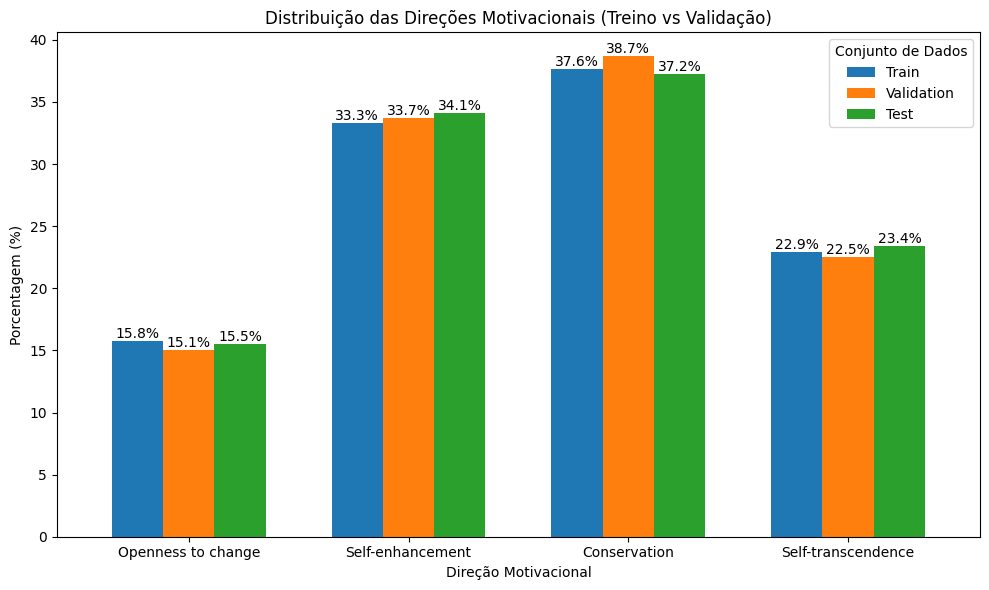

In [60]:
# prompt: Plot para Analise da distribuição entre Openness to change	Self-enhancement	Conservation	Self-transcendence

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage distribution for each motivational direction in the training data
train_distribution = df_labels_train_direction[['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].mean() * 100

# Calculate the percentage distribution for each motivational direction in the validation data
valid_distribution = df_labels_valid_direction[['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].mean() * 100

# # Calculate the percentage distribution for each motivational direction in the test data
test_distribution = df_labels_test_direction[['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].mean() * 100

# Combine the distributions into a single DataFrame for plotting
distribution_df = pd.DataFrame({
    'Train': train_distribution,
    'Validation': valid_distribution,
    'Test': test_distribution
})

# Plotting the distribution
fig, ax = plt.subplots(figsize=(10, 6))

distribution_df.plot(kind='bar', ax=ax, rot=0, width=0.7)

ax.set_title('Distribuição das Direções Motivacionais (Treino vs Validação)')
ax.set_ylabel('Porcentagem (%)')
ax.set_xlabel('Direção Motivacional')
ax.legend(title='Conjunto de Dados')

# Add percentage labels on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()

DataFrame de Labels de Treino agrupado por Valor:


,Text-ID,Sentence-ID,Achievement,Benevolence: caring,Benevolence: dependability,Conformity: interpersonal,Conformity: rules,Face,Hedonism,Humility,...,Power: resources,Security: personal,Security: societal,Self-direction: action,Self-direction: thought,Stimulation,Tradition,Universalism: concern,Universalism: nature,Universalism: tolerance
0,EN_001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,EN_001,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,EN_001,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,EN_001,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,EN_001,7,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0



DataFrame de Labels de Validação agrupado por Valor:


,Text-ID,Sentence-ID,Achievement,Benevolence: caring,Benevolence: dependability,Conformity: interpersonal,Conformity: rules,Face,Hedonism,Humility,...,Power: resources,Security: personal,Security: societal,Self-direction: action,Self-direction: thought,Stimulation,Tradition,Universalism: concern,Universalism: nature,Universalism: tolerance
0,EN_003,3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,EN_003,4,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,EN_003,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,EN_003,6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,EN_003,7,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0



DataFrame de Labels de Teste agrupado por Valor:


,Text-ID,Sentence-ID,Achievement,Benevolence: caring,Benevolence: dependability,Conformity: interpersonal,Conformity: rules,Face,Hedonism,Humility,...,Power: resources,Security: personal,Security: societal,Self-direction: action,Self-direction: thought,Stimulation,Tradition,Universalism: concern,Universalism: nature,Universalism: tolerance
0,EN_002,6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,EN_002,7,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,EN_002,8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,EN_002,11,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,EN_002,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1



Distribuição Percentual dos 19 Valores de Schwartz:


,Train,Validation,Test
Achievement,12.717046,12.816397,12.307692
Benevolence: caring,4.353143,4.395604,4.348379
Benevolence: dependability,3.737670,3.741203,3.763509
Conformity: interpersonal,2.677916,2.704038,2.517483
Conformity: rules,11.824407,12.581800,12.536554
Face,3.521643,3.765897,3.521933
Hedonism,1.654846,1.333498,1.703751
Humility,0.456509,0.530930,0.406866
Power: dominance,8.718513,8.507223,8.289892
Power: resources,9.525556,9.680207,11.036236


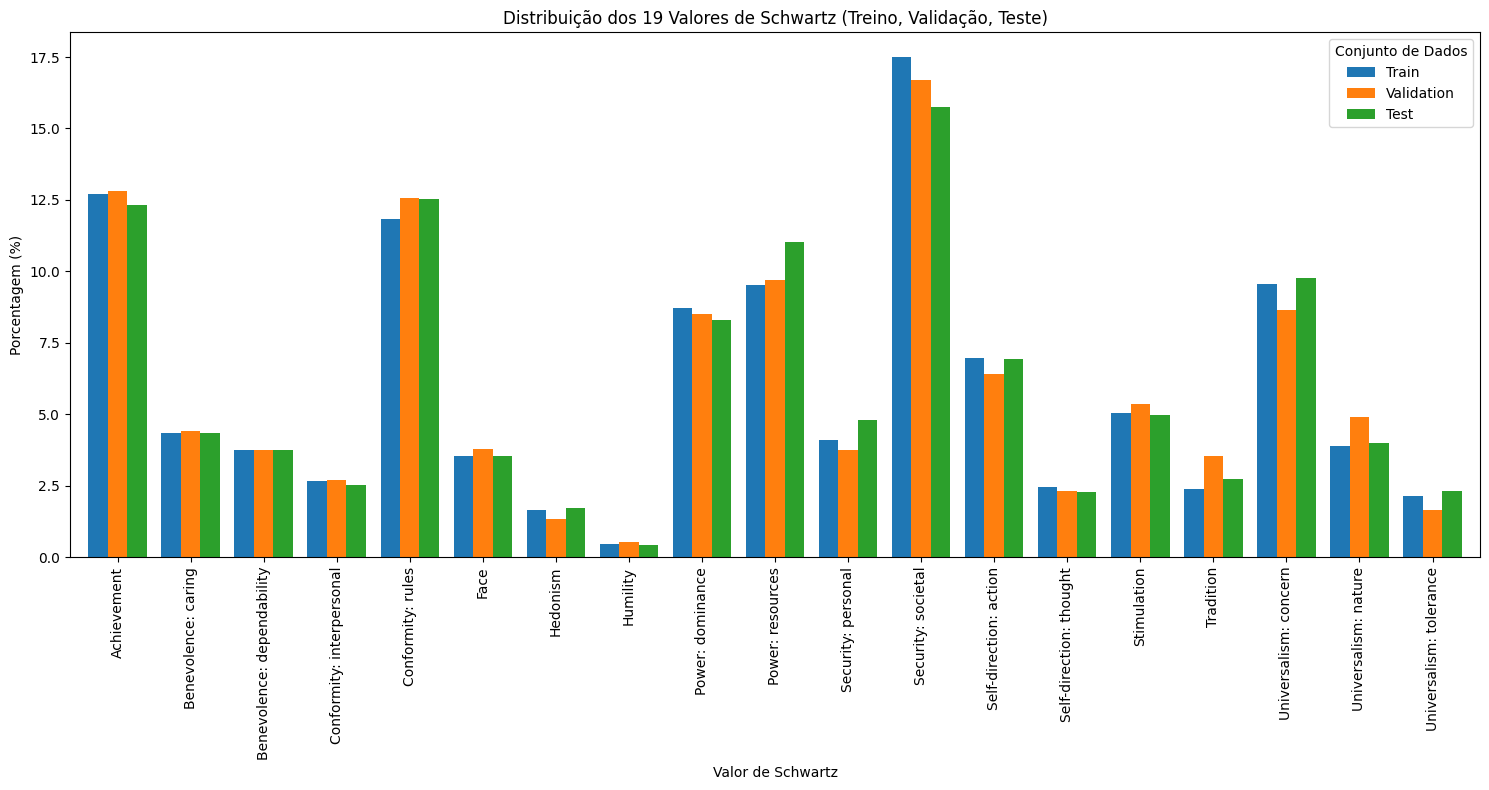

In [63]:
# prompt: Implementar agrupar_por_valor

def agrupar_por_valor(df_original: pd.DataFrame) -> pd.DataFrame:
    """
    Agrupa os valores humanos de Schwartz, desconsiderando 'attained' ou 'constrained'.

    A função transforma um DataFrame com múltiplos valores binários ('valor attained',
    'valor constrained') em um DataFrame com colunas binárias que representam apenas
    os 19 valores de Schwartz (ex: 'Self-direction: thought').

    Args:
        df_original: O DataFrame contendo os dados do arquivo CSV.

    Returns:
        Um novo DataFrame com as colunas de identificação originais e as
        19 novas colunas que representam os valores agregados.
    """
    # Mapeamento dos nomes originais para os nomes dos 19 valores base
    # Assumimos que os nomes base são os nomes sem ' attained' ou ' constrained'
    colunas_originais = [col for col in df_original.columns if ' attained' in col or ' constrained' in col]
    nomes_base = set()
    for col in colunas_originais:
        if ' attained' in col:
            nomes_base.add(col.removesuffix(' attained'))
        elif ' constrained' in col:
            nomes_base.add(col.removesuffix(' constrained'))

    nomes_base = sorted(list(nomes_base)) # Garante ordem consistente

    # Identifica as colunas que não serão agregadas (ex: ID, Sentence-ID)
    colunas_identificadoras = [col for col in df_original.columns if col not in colunas_originais]

    # Cria a base para o novo DataFrame, mantendo as colunas identificadoras
    df_resultado = df_original[colunas_identificadoras].copy()

    # Itera sobre os nomes base para criar as 19 novas colunas agregadas
    for nome_base in nomes_base:
        colunas_para_agregar = [f'{nome_base} attained', f'{nome_base} constrained']
        # Filtra as colunas que realmente existem no DataFrame original
        colunas_existentes = [col for col in colunas_para_agregar if col in df_original.columns]

        if not colunas_existentes:
            df_resultado[nome_base] = 0 # Se nenhuma coluna do par existir, o resultado é 0
            continue

        # Agrega: se qualquer uma das colunas 'attained' ou 'constrained' for 1, o valor agregado é 1
        df_resultado[nome_base] = df_original[colunas_existentes].any(axis=1).astype(int)

    return df_resultado

# Aplicar essa tranformação as labels de treino, validação e teste
df_labels_train_valor = agrupar_por_valor(df_labels_train)
df_labels_valid_valor = agrupar_por_valor(df_labels_valid)
df_labels_test_valor = agrupar_por_valor(df_labels_test)

print("DataFrame de Labels de Treino agrupado por Valor:")
display(df_labels_train_valor.head())

print("\nDataFrame de Labels de Validação agrupado por Valor:")
display(df_labels_valid_valor.head())

print("\nDataFrame de Labels de Teste agrupado por Valor:")
display(df_labels_test_valor.head())

# Calcular a distribuição percentual para cada valor nos dados de treino
train_value_distribution = df_labels_train_valor.drop(columns=['Text-ID', 'Sentence-ID']).mean() * 100

# Calcular a distribuição percentual para cada valor nos dados de validação
valid_value_distribution = df_labels_valid_valor.drop(columns=['Text-ID', 'Sentence-ID']).mean() * 100

# Calcular a distribuição percentual para cada valor nos dados de teste
test_value_distribution = df_labels_test_valor.drop(columns=['Text-ID', 'Sentence-ID']).mean() * 100

# Combinar as distribuições em um único DataFrame para visualização
value_distribution_df = pd.DataFrame({
    'Train': train_value_distribution,
    'Validation': valid_value_distribution,
    'Test': test_value_distribution
}).sort_index() # Ordena por nome do valor para melhor visualização

print("\nDistribuição Percentual dos 19 Valores de Schwartz:")
display(value_distribution_df)

# Plotting the distribution of 19 values
fig, ax = plt.subplots(figsize=(15, 8))

value_distribution_df.plot(kind='bar', ax=ax, rot=90, width=0.8)

ax.set_title('Distribuição dos 19 Valores de Schwartz (Treino, Validação, Teste)')
ax.set_ylabel('Porcentagem (%)')
ax.set_xlabel('Valor de Schwartz')
ax.legend(title='Conjunto de Dados')

# Add percentage labels on top of the bars (optional, can make plot cluttered with many bars)
# for container in ax.containers:
#     ax.bar_label(container, fmt='%.1f%%')

plt.tight_layout()
plt.show()


In [64]:
# prompt: # Salvar em .tsv df_*_*_valor como final_sentences e final_labels

# Salvar em .tsv df_sentences_* como final_sentences e df_labels_*_valor como final_labels

# Treino
df_sentences_train.to_csv(folder_treino + "final_sentences.tsv", sep='\t', index=False)
df_labels_train_valor.to_csv(folder_treino + "final_labels.tsv", sep='\t', index=False)

# Teste
df_sentences_test.to_csv(folder_teste + "final_sentences.tsv", sep='\t', index=False)
df_labels_test_valor.to_csv(folder_teste + "final_labels.tsv", sep='\t', index=False)

# Validação
df_sentences_valid.to_csv(folder_validacao + "final_sentences.tsv", sep='\t', index=False)
df_labels_valid_valor.to_csv(folder_validacao + "final_labels.tsv", sep='\t', index=False)

print("Arquivos final_sentences.tsv e final_labels.tsv salvos nas respectivas pastas de treino, teste e validação.")


Arquivos final_sentences.tsv e final_labels.tsv salvos nas respectivas pastas de treino, teste e validação.
